In [139]:
import numpy as np
from astropy.table import Table, vstack, join, unique

from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky, search_around_sky
from astropy import units as u
from tqdm import tqdm

import os
import psycopg2

from desitarget.targets import decode_targetid, encode_targetid, resolve
from desitarget.io import releasedict, release_to_photsys

import requests
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.visualization.wcsaxes import SphericalCircle

In [3]:
# load tf targets table
pv_tf = Table.read('/global/cfs/cdirs/desi/science/td/pv/desi_pv/savepath_dr9_corr/pv_tf.fits', format='fits')
pv_tf[:5]

OBJID,BRICKID,BRICKNAME,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE,PVTYPE,PVPRIORITY,POINTINGID,SGA_ID
int64,int32,bytes8,float64,float64,float32,float32,float32,bool,bytes3,int32,int64,int64
262,520796,2267p350,226.62204270638287,34.98227660676318,0.0,0.0,2015.5,True,TFT,1,1,1006008
262,520796,2267p350,226.62323955692426,34.98099178744529,0.0,0.0,2015.5,False,TFT,2,2,1006008
262,520796,2267p350,226.62443636990747,34.97970695638398,0.0,0.0,2015.5,True,TFT,1,3,1006008
2738,514840,2263p337,226.40142777879575,33.68537046528162,0.0,0.0,2015.5,True,TFT,1,1,4331
2738,514840,2263p337,226.40426477759235,33.68450278837041,0.0,0.0,2015.5,False,TFT,2,2,4331


In [4]:
master_table = Table.read('/pscratch/sd/n/nravi/pv_rot_curves/desi_pv_tf_master_healpix_rotcurve.fits')
master_table[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,MEAN_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_RA,STD_FIBER_DEC,SPECTYPE,PHOTSYS,ROT_CURVE
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes1,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454,0.03927420444753712,1.0000000170652443,--,--,--,--,--,--,0.0
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454,0.03927420444753712,1.0000000170652443,--,--,--,--,--,--,0.0
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136,0.012960487467698754,0.3300000056318236,--,--,--,--,--,--,0.0
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595,0.012960487467685656,0.33000000563149007,--,--,--,--,--,--,0.0
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195,0.026313716979861984,0.6700000114340222,--,--,--,--,--,--,0.0


In [5]:
ids, counts = np.unique(master_table[~master_table['FILENAME'].mask]['SGA_ID'], return_counts=True)
sga_id = ids[np.argmax(counts)]

In [6]:
sga = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
sga[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [45]:
sga_dict = {}
for i in range(len(sga)):
    sga_dict[sga['SGA_ID'][i]] = i

In [128]:
master_table[master_table['SGA_ID']==sga_id][15:30]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,MEAN_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_RA,STD_FIBER_DEC,SPECTYPE,PHOTSYS,ROT_CURVE
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes1,float64
1083441357520907,208.761444858952,5.39948060917962,26432,sv3,0.0637327561525142,5.29574560704098e-05,4,5.60704569122754,fuji/healpix/sv3/dark/264/26432/redrock-sv3-dark-26432.fits,TFT,547778,208.7614448589523,5.399480609179624,0.06803759341778508,1.0000000591836442,--,--,--,--,--,--,1.0
39627914962013611,208.743487213374,5.33383414667272,26432,sv3,0.00462884657631763,4.90232514116244e-06,0,6323.91901983946,fuji/healpix/sv3/bright/264/26432/redrock-sv3-bright-26432.fits,TFT,547778,208.74348721337373,5.333834146672721,0.0,0.0,--,--,--,--,--,--,1.0
1070241199161349,208.749412809371,5.35549753719813,26432,sv3,1.52905722130535,0.000140484931635865,4,3.14328634738922,fuji/healpix/sv3/bright/264/26432/redrock-sv3-bright-26432.fits,TFT,547778,208.7494128093705,5.355497537198131,0.02245240582783662,0.3300000195301256,--,--,--,--,--,--,1.0
1083435338694661,208.749412809371,5.35549753719813,26432,sv3,0.00507397495818972,5.23344718138087e-05,0,110.570778177287,fuji/healpix/sv3/dark/264/26432/redrock-sv3-dark-26432.fits,TFT,547778,208.7494128093705,5.355497537198131,0.02245240582783662,0.3300000195301256,--,--,--,--,--,--,1.0
1070247217987594,208.755518408261,5.37781733453269,26432,sv3,0.528451150168133,0.000106005130313453,4,1.68334472924471,fuji/healpix/sv3/bright/264/26432/redrock-sv3-bright-26432.fits,TFT,547778,208.75551840826128,5.377817334532686,0.04558518758988767,0.6700000396526252,--,--,--,--,--,--,1.0
1083441357520906,208.755518408261,5.37781733453269,26432,sv3,0.000114926282582196,5.57883704550061e-05,0,62.9426100458277,fuji/healpix/sv3/dark/264/26432/redrock-sv3-dark-26432.fits,TFT,547778,208.75551840826128,5.377817334532686,0.04558518758988767,0.6700000396526252,--,--,--,--,--,--,1.0
2394053199003655,208.725533409266,5.26818716334567,26090,main,0.29371281063022,0.000101612650388115,4,3.62446214351803,iron/healpix/main/bright/260/26090/redrock-main-bright-26090.fits,EXT,547778,208.72553340926592,5.268187163345671,0.06803759341745368,1.0000000591787734,--,--,--,--,--,--,1.0
1070241199161346,208.725533409266,5.26818716334567,26090,sv3,1.37651495080231,0.000132420732257359,4,3.18402267992496,iron/healpix/sv3/bright/260/26090/redrock-sv3-bright-26090.fits,EXT,547778,208.72553340926592,5.268187163345671,0.06803759341745368,1.0000000591787734,--,--,--,--,--,--,1.0
1083435338694658,208.725533409266,5.26818716334567,26090,sv3,1.53471814562392,0.000125293106530875,4,3.13327747583389,iron/healpix/sv3/dark/260/26090/redrock-sv3-dark-26090.fits,EXT,547778,208.72553340926592,5.268187163345671,0.06803759341745368,1.0000000591787734,--,--,--,--,--,--,1.0


#### test a single target

In [27]:
db = psycopg2.connect(host='specprod-db.desi.lbl.gov', database='desi', user='desi', password='')
cursor = db.cursor()

query = f"""SELECT f.targetid, f.target_ra, f.target_dec, zp.z, zp.mean_fiber_ra, zp.mean_fiber_dec
            FROM iron.fiberassign AS f 
            JOIN iron.zpix AS zp ON f.targetid = zp.targetid WHERE f.targetid = 2389655152492546;"""

print(query)

cursor.execute(query)

print('1')
rows = cursor.fetchall()
print('2')


SELECT f.targetid, f.target_ra, f.target_dec, zp.z, zp.mean_fiber_ra, zp.mean_fiber_dec
            FROM iron.fiberassign AS f 
            JOIN iron.zpix AS zp ON f.targetid = zp.targetid WHERE f.targetid = 2389655152492546;
1
2


#### test ellipse query

In [66]:
# from sga, we need ra2, dec2, major, ratio, pa -- values of galaxy. ra1, dec1 is the data
# major is semi-major axis in degrees, pa in degrees

idx = sga_dict[sga_id]
ra2 = sga['RA'][idx]
dec2 = sga['DEC'][idx]
major = (sga['D26'][idx]*0.5*u.arcmin).to(u.degree).value
ratio = sga['BA'][idx]
pa = sga['PA'][idx]

#q3c_ellipse_join(ra1, dec1, ra2, dec2, major, ratio, pa)

db = psycopg2.connect(host='specprod-db.desi.lbl.gov', database='desi', user='desi', password='')
cursor = db.cursor()

query = f"""SELECT f.targetid, f.target_ra, f.target_dec, zp.z, zp.mean_fiber_ra, zp.mean_fiber_dec
            FROM iron.fiberassign AS f 
            JOIN iron.zpix AS zp ON f.targetid = zp.targetid 
            WHERE q3c_ellipse_join(f.target_ra, f.target_dec, {str(ra2)}, {dec2}, {major}, {ratio}, {pa});"""


print(query)

cursor.execute(query)

print('1')
rows = cursor.fetchall()
print('2')

SELECT f.targetid, f.target_ra, f.target_dec, zp.z, zp.mean_fiber_ra, zp.mean_fiber_dec
            FROM iron.fiberassign AS f 
            JOIN iron.zpix AS zp ON f.targetid = zp.targetid 
            WHERE q3c_ellipse_join(f.target_ra, f.target_dec, 208.74348721337373, 5.333834146672721, 0.06803758939107259, 0.24618208408355713, 15.2342529296875);
1
2


In [68]:
targs = Table(list(map(list, zip(*rows))),
                       names=['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'Z', 'MEAN_FIBER_RA', 'MEAN_FIBER_DEC'])

In [69]:
targs

TARGETID,TARGET_RA,TARGET_DEC,Z,MEAN_FIBER_RA,MEAN_FIBER_DEC
int64,float64,float64,float64,float64,float64
1083435338694659,208.73145774292163,5.289850725016704,1.4239144008439961,208.73144581277893,5.289866626969295
1083435338694659,208.73145774292163,5.289850725016704,1.4239144008439961,208.73144581277893,5.289866626969295
1083435338694659,208.73145774292163,5.289850725016704,1.4239144008439961,208.73144581277893,5.289866626969295
1070241199161347,208.73145774292163,5.289850725016704,1.5703382353559283,208.73145668164727,5.289843962330692
1070241199161347,208.73145774292163,5.289850725016704,1.5703382353559283,208.73145668164727,5.289843962330692
1070241199161347,208.73145774292163,5.289850725016704,1.5703382353559283,208.73145668164727,5.289843962330692
1083435338694659,208.73145774292163,5.289850725016704,1.4239144008439961,208.73144581277893,5.289866626969295
2394053199003653,208.73271447302625,5.294446018755208,1.3823920156108027,208.73271493356015,5.294442952606956
2394053199003653,208.73271447302625,5.294446018755208,1.3823920156108027,208.73271493356015,5.294442952606956


#### ellipse query with everything

In [149]:
idx = sga_dict[sga_id]
ra2 = sga['RA'][idx]
dec2 = sga['DEC'][idx]
major = (sga['D26'][idx]*0.5*u.arcmin).to(u.degree).value
ratio = sga['BA'][idx]
pa = sga['PA'][idx]

#q3c_ellipse_join(ra1, dec1, ra2, dec2, major, ratio, pa)

db = psycopg2.connect(host='specprod-db.desi.lbl.gov', database='desi', user='desi', password='')
cursor = db.cursor()



query = f"""SELECT f.targetid, f.tileid, f.target_ra, f.target_dec, zp.healpix, zp.survey, zp.program,
            zp.z, zp.zerr, zp.zwarn, zp.chi2, zp.deltachi2, zp.mean_fiber_ra, zp.mean_fiber_dec,
            zp.std_fiber_ra, zp.std_fiber_dec, zp.spectype
            FROM iron.fiberassign AS f 
            JOIN iron.zpix AS zp ON f.targetid = zp.targetid 
            WHERE q3c_ellipse_join(f.target_ra, f.target_dec, {str(ra2)}, {dec2}, {major}, {ratio}, {pa});"""

print(query)

cursor.execute(query)

rows = cursor.fetchall()


targs = Table(list(map(list, zip(*rows))), names=['TARGETID', 'TILEID', 'TARGET_RA', 'TARGET_DEC', 'HEALPIX', 'SURVEY', 'PROGRAM',
                              'Z', 'ZERR', 'ZWARN', 'CHI2', 'DELTACHI2', 'MEAN_FIBER_RA', 'MEAN_FIBER_DEC',
                             'STD_FIBER_RA', 'STD_FIBER_DEC', 'SPECTYPE'],
              dtype=['int64', 'int64', 'float64', 'float64', 'int64', 'S4', 'S6',
                     'float64', 'float64', 'int64', 'float64', 'float64', 'float64', 'float64',
                     'float64', 'float64', 'S6'])

SELECT f.targetid, f.tileid, f.target_ra, f.target_dec, zp.healpix, zp.survey, zp.program,
            zp.z, zp.zerr, zp.zwarn, zp.chi2, zp.deltachi2, zp.mean_fiber_ra, zp.mean_fiber_dec,
            zp.std_fiber_ra, zp.std_fiber_dec, zp.spectype
            FROM iron.fiberassign AS f 
            JOIN iron.zpix AS zp ON f.targetid = zp.targetid 
            WHERE q3c_ellipse_join(f.target_ra, f.target_dec, 208.74348721337373, 5.333834146672721, 0.06803758939107259, 0.24618208408355713, 15.2342529296875);


In [150]:
targs

TARGETID,TILEID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,PROGRAM,Z,ZERR,ZWARN,CHI2,DELTACHI2,MEAN_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_RA,STD_FIBER_DEC,SPECTYPE
int64,int64,float64,float64,int64,bytes4,bytes6,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes6
1083435338694659,140,208.73145774292163,5.289850725016704,26090,sv3,dark,1.4239144008439961,9.624389592302944e-05,4,8034.755547940731,4.10942218080163,208.73144581277893,5.289866626969295,0.033814806,0.056036282,GALAXY
1083435338694659,141,208.73145774292163,5.289850725016704,26090,sv3,dark,1.4239144008439961,9.624389592302944e-05,4,8034.755547940731,4.10942218080163,208.73144581277893,5.289866626969295,0.033814806,0.056036282,GALAXY
1083435338694659,142,208.73145774292163,5.289850725016704,26090,sv3,dark,1.4239144008439961,9.624389592302944e-05,4,8034.755547940731,4.10942218080163,208.73144581277893,5.289866626969295,0.033814806,0.056036282,GALAXY
1070241199161347,152,208.73145774292163,5.289850725016704,26090,sv3,bright,1.5703382353559283,0.00032935327824803106,4,7475.171020455658,1.2493662163615227,208.73145668164727,5.289843962330692,0.10052644,0.08262856,GALAXY
1070241199161347,153,208.73145774292163,5.289850725016704,26090,sv3,bright,1.5703382353559283,0.00032935327824803106,4,7475.171020455658,1.2493662163615227,208.73145668164727,5.289843962330692,0.10052644,0.08262856,GALAXY
1070241199161347,156,208.73145774292163,5.289850725016704,26090,sv3,bright,1.5703382353559283,0.00032935327824803106,4,7475.171020455658,1.2493662163615227,208.73145668164727,5.289843962330692,0.10052644,0.08262856,GALAXY
1083435338694659,457,208.73145774292163,5.289850725016704,26090,sv3,dark,1.4239144008439961,9.624389592302944e-05,4,8034.755547940731,4.10942218080163,208.73144581277893,5.289866626969295,0.033814806,0.056036282,GALAXY
2394053199003653,21691,208.73271447302625,5.294446018755208,26090,main,bright,1.3823920156108027,6.994066469276628e-05,4,7945.44548869133,8.649884775280952,208.73271493356015,5.294442952606956,0.0010890431,0.04419495,GALAXY
2394053199003653,24817,208.73271447302625,5.294446018755208,26090,main,bright,1.3823920156108027,6.994066469276628e-05,4,7945.44548869133,8.649884775280952,208.73271493356015,5.294442952606956,0.0010890431,0.04419495,GALAXY


In [118]:
# compare the pv targs for this galaxy, targets in master table, and targets returned by query
unique_ids = np.unique(targs['TARGETID'])

In [122]:
for i in unique_ids:
    if i in master_table['TARGETID']:
        print(i)

1070241199161347
1070241199161348
1070241199161349
1070247217987594
1083435338694659
1083435338694660
1083435338694661
1083441357520906
2389655152492546
2394053199003653
2394053199003654
2394059217829889
39627914962013611


In [123]:
def get_cutout(SGA_ID, ra, dec, size, cache_dir, verbose=False):
    '''Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    SGA_ID : int
        SGA ID for galaxy.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    size : float
        size of cutout.
    cache_dir : string
        cache location
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    '''
    
    # Either load an existing image or download a cutout.
    img_name = cache_dir + '{}.jpg'.format(SGA_ID)
    
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))

    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [145]:
npix

512

/pscratch/sd/n/nravi/pv_rot_curves/cache/547778.jpg exists.


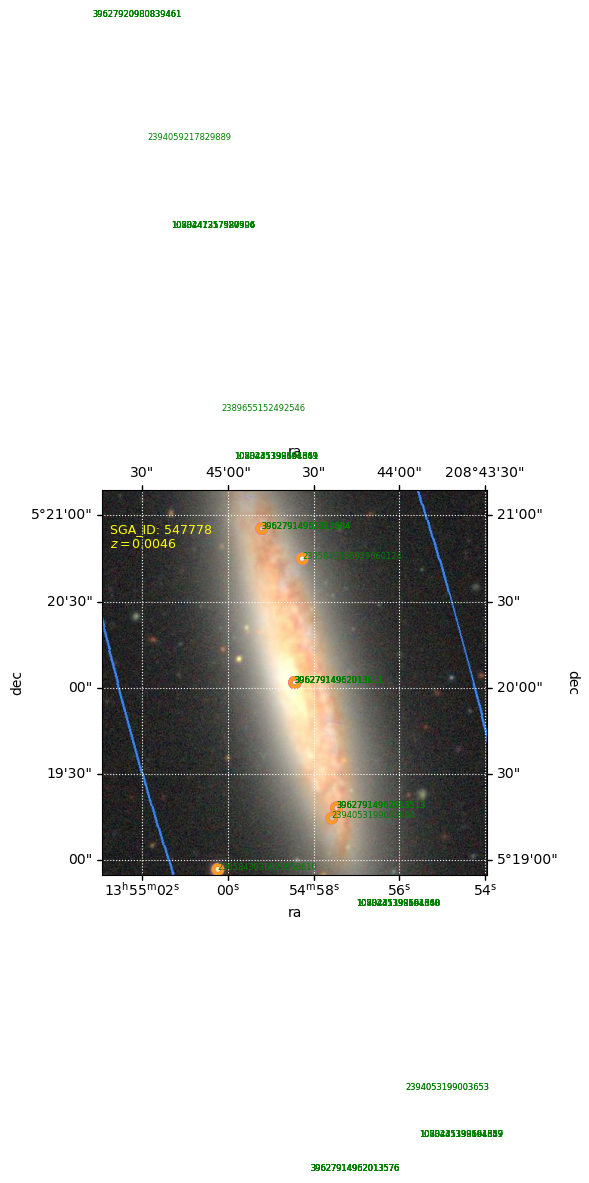

In [148]:
# targ_list = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]

ra, dec = ra2, dec2

# D26 in arcmin
d26 = sga['D26'][sga_dict[sga_id]]
z = 0.0046

npix = np.minimum(int(2 * d26*60/0.262), 512)
# npix = int(2 * d26*60/0.262)

cache_dir = '/pscratch/sd/n/nravi/pv_rot_curves/cache/'

img_file, wcs = get_cutout(sga_id, ra, dec, size=npix, cache_dir=cache_dir,verbose=True)
img = mpl.image.imread(img_file)

fig1 = plt.figure(figsize=(5,5))

ax = fig1.add_subplot(111, projection=wcs)
ax.imshow(np.flip(img, axis=0))
ax.set(xlabel='ra', ylabel='dec')
ax.text(int(0.02*npix), int(0.85*npix), 'SGA_ID: {}\n$z={{{:.4f}}}$'.format(sga_id, z), fontsize=9, color='yellow')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted');

# Add the location of the DESI fibers.
# SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                     edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                     transform=ax.get_transform('icrs'))
r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                     edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                     transform=ax.get_transform('icrs'))
ax.add_patch(r1)
ax.add_patch(r2)

for targ in targs:
    ra, dec = targ['TARGET_RA'], targ['TARGET_DEC']
    
    edgecolor2 = 'orange'

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)
    
    ax.text(ra, dec, str(targ['TARGETID']), transform=ax.get_transform('icrs'), color='green', fontsize=6)

# fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
